In [35]:
import numpy as np
import cmath as c
import matplotlib.pyplot as plt
import sympy as sp
from scipy.optimize import fsolve

Physical constants:

In [2]:
# copied from constants-units

EAU = 27.2114
IAU = 3.5e16
LAU = 0.052918
TAU = 2.419e-17
alpha = 1. /137
c = 1/alpha


In [3]:
# #EAU = 27.2114
# IAU = 3.5e16
# #LAU = 0.052918
# TAU = 2.419e-17
# #alpha = 1. /137
# c = 2.998e8  # Speed of light in m/s
# LAU = 5.29177e-11  # Bohr radius in meters
# #c = 1/alpha


Field configurations:

In [12]:
### in SI units
wavelength = 800 #e-9 #Wavelength in nm
Int_0 = 4e14 #Intensity in W/cm2
Ip = 0.5 * 13.5984 # Hydrogen gas target ionization potential in eV

#### conversion to atomic units
omega = 2 * np.pi * LAU * c / wavelength  # Angular frequency
TC = 2 * np.pi / omega  # Optical cycle period

Plot field shape:

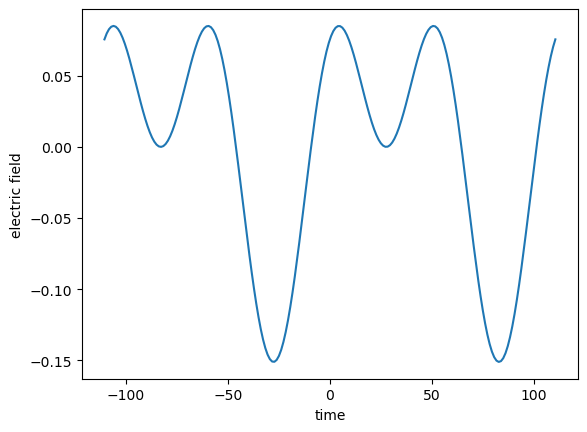

In [5]:
t_list = np.linspace(-TC, TC, 200)  #time list

#define a function for a two-colour field, with mixing angle theta and phase shift phi
def beam(theta, phi, r, s):
    Int_1 = Int_0 * (np.cos(theta))**2  #Intensity of beam 1
    Int_2 = Int_0 * (np.sin(theta))**2  #Intensity of beam 1
    omega_1 = r * omega  #Frequency of beam 1
    omega_2 = s * omega  #Frequency of beam 1

    E_01 = np.sqrt(Int_1 / IAU)  #field strength of beam 1
    E_02 = np.sqrt(Int_2 / IAU)  #field strength of beam 2

    e_field = []  #create empty lists to store electric field values for each point in time

    for i in t_list:
        beam_1 = E_01 * np.sin(omega_1 * i)
        beam_2 = E_02 * np.sin((omega_2 * i) + phi)
        total_beam = beam_1 + beam_2

        e_field.append(total_beam)

    #return e_field
    plt.plot(t_list, e_field, label='two-colour field')
    plt.xlabel("time")
    plt.ylabel("electric field")
    plt.show()

beam(np.pi / 4, np.pi /2, 1, 2)

Creating a timespace domain to make initial guesses:

In [60]:
# Define grid parameters
x_values = np.linspace(0, TC, 10)  # 50 points from 0 to 100
y_values = np.linspace(0, TC/2, 10)   # 50 points from 0 to 50

# Create meshgrid
X, Y = np.meshgrid(x_values, y_values)

# Stack into a matrix where each row is a (x, y) point
grid_points = np.column_stack([X.ravel(), Y.ravel()])

print(grid_points)

[[  0.           0.        ]
 [ 12.26093213   0.        ]
 [ 24.52186426   0.        ]
 [ 36.78279639   0.        ]
 [ 49.04372852   0.        ]
 [ 61.30466065   0.        ]
 [ 73.56559278   0.        ]
 [ 85.82652491   0.        ]
 [ 98.08745704   0.        ]
 [110.34838918   0.        ]
 [  0.           6.13046607]
 [ 12.26093213   6.13046607]
 [ 24.52186426   6.13046607]
 [ 36.78279639   6.13046607]
 [ 49.04372852   6.13046607]
 [ 61.30466065   6.13046607]
 [ 73.56559278   6.13046607]
 [ 85.82652491   6.13046607]
 [ 98.08745704   6.13046607]
 [110.34838918   6.13046607]
 [  0.          12.26093213]
 [ 12.26093213  12.26093213]
 [ 24.52186426  12.26093213]
 [ 36.78279639  12.26093213]
 [ 49.04372852  12.26093213]
 [ 61.30466065  12.26093213]
 [ 73.56559278  12.26093213]
 [ 85.82652491  12.26093213]
 [ 98.08745704  12.26093213]
 [110.34838918  12.26093213]
 [  0.          18.3913982 ]
 [ 12.26093213  18.3913982 ]
 [ 24.52186426  18.3913982 ]
 [ 36.78279639  18.3913982 ]
 [ 49.04372852

In [25]:
realtimes = np.linspace(0, TC, 50)
imagtimes = np.linspace(0, TC/2, 50)

timespace = np.array(realtimes + imagtimes*1j)
print(timespace)

[  0.         +0.j           2.25200794 +1.12600397j
   4.50401588 +2.25200794j   6.75602383 +3.37801191j
   9.00803177 +4.50401588j  11.26003971 +5.63001986j
  13.51204765 +6.75602383j  15.7640556  +7.8820278j
  18.01606354 +9.00803177j  20.26807148+10.13403574j
  22.52007942+11.26003971j  24.77208737+12.38604368j
  27.02409531+13.51204765j  29.27610325+14.63805163j
  31.52811119+15.7640556j   33.78011914+16.89005957j
  36.03212708+18.01606354j  38.28413502+19.14206751j
  40.53614296+20.26807148j  42.7881509 +21.39407545j
  45.04015885+22.52007942j  47.29216679+23.64608339j
  49.54417473+24.77208737j  51.79618267+25.89809134j
  54.04819062+27.02409531j  56.30019856+28.15009928j
  58.5522065 +29.27610325j  60.80421444+30.40210722j
  63.05622239+31.52811119j  65.30823033+32.65411516j
  67.56023827+33.78011914j  69.81224621+34.90612311j
  72.06425416+36.03212708j  74.3162621 +37.15813105j
  76.56827004+38.28413502j  78.82027798+39.41013899j
  81.07228592+40.53614296j  83.32429387+41.6621

Defining action landscape:

In [37]:
np.real(2+3j)

2.0

In [45]:
p = 0.5507876985417118  #momentum

def action_drv_mono(t_arr):
    #S_mono = Ip*t + 0.5*p**2*t - (p/omega)*np.cos(omega*t + np.pi/2) + 0.5*t - (1/4*omega)*np.sin(2*omega*t + np.pi)
    t = t_arr[0] + t_arr[1]*1j
    
    dS_dt_mono_real = np.real(Ip + (p + (np.sin(omega * t))**2))
    dS_dt_mono_imag = np.imag(Ip + (p + (np.sin(omega * t))**2))


    return np.array([dS_dt_mono_real, dS_dt_mono_imag])

#find saddle points:
# ts = fsolve(action_mono, timespace)

# print(ts)    
#     return dS_dt_mono

# #find saddle points:
# ts = fsolve(action_drv_mono, timespace)

In [48]:
action_drv_mono(np.array([1,2]))

array([7.34028607, 0.0130526 ])

In [53]:
fsolve(action_drv_mono, np.array([22,0]))

array([-220.68995935,    0.        ])

In [55]:
def f(x):
    try:
        if x <= -3 or x >= 3:  # Example undefined range
            return np.nan  # Return NaN for undefined cases
        return np.log(3 - x) - np.sqrt(x + 4)  # Example function
    except:
        return np.nan  # Catch any unexpected errors

# Wrapper function to ensure f(x) is defined
def safe_f(x):
    val = f(x)
    return val if not np.isnan(val) else np.inf  # Assign a large number to avoid invalid solutions

# Generate valid initial guesses within range [-5,5]
x_vals = np.linspace(-5, 5, 100)
valid_x_vals = np.array([x for x in x_vals if not np.isnan(f(x))])  # Filter out undefined values

# Use fsolve with filtered initial guesses
roots = []
for x0 in valid_x_vals:
    try:
        root = fsolve(safe_f, x0)[0]  # Solve f(x) = 0 from this initial guess
        if -5 <= root <= 5 and not np.isnan(f(root)):  # Ensure root is within valid range
            roots.append(root)
    except:
        pass  # Ignore any errors

# Remove duplicates (since fsolve may find the same root multiple times)
roots = np.unique(np.round(roots, 6))  # Round to remove near-duplicates

print("Roots:", roots)

Roots: [-1.6428]


In [54]:
fsolve(action_drv_mono, timespace)

TypeError: fsolve: there is a mismatch between the input and output shape of the 'func' argument 'action_drv_mono'.Shape should be (50,) but it is (2,).